# Imports, data loading

In [3]:
from tqdm.notebook import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np
import json
from sklearn.preprocessing import normalize

behaviors_path = 'MINDsmall_train/behaviors.tsv'
news_path = 'MINDsmall_train/news.tsv'
news_data = pd.read_csv(news_path, sep='\t', header=None, names=['ArticleID', 'Category', 'SubCategory', 'Title', 'Abstract', 'URL', 'TitleEntities', 'AbsEntities'])

news_data['Title'] = news_data['Title'].fillna('')
news_data['Abstract'] = news_data['Abstract'].fillna('')

# Concatenating title and abstract for a comprehensive representation
news_data['content'] = news_data['Title'] + " " + news_data['Abstract']

# Vectorizing the content using TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=500)

tfidf_matrix = tfidf_vectorizer.fit_transform(news_data['content'])

In [4]:
news_data.ArticleID.nunique()

51282

# Loading entity embeddings

In [5]:
def load_entity_embeddings(file_path):
    embeddings = {}
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            values = line.split()
            entity_id = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[entity_id] = vector
    return embeddings

entity_embeddings_path = './MINDsmall_train/entity_embedding.vec'
entity_embeddings = load_entity_embeddings(entity_embeddings_path)

In [6]:
def article_to_embedding(article_entities, entity_embeddings):
    try:
        q_entities = [entity['WikidataId'] for entity in json.loads(article_entities)]
    except:
        q_entities = []
    embeddings = [entity_embeddings[entity] for entity in q_entities if entity in entity_embeddings]
    
    if embeddings:
        article_embedding = np.mean(embeddings, axis=0)
    else:
        article_embedding = np.zeros(next(iter(entity_embeddings.values())).shape)
    return article_embedding

def embeddings_count(article_entities):
    try:
        return len([entity['WikidataId'] for entity in json.loads(article_entities)])
    except:
        return 0

def combine_embs_hstack(row): #Kanskje mean istedenfor hstack
    if row["AbsEmbeddingsCount"] == 0 and row["TitleEmbeddingsCount"] != 0:
        return np.hstack((row["TitleEmbs"], row["TitleEmbs"], row["TfidfEmbs"]))
    elif row["AbsEmbeddingsCount"] != 0 and row["TitleEmbeddingsCount"] == 0:
        return np.hstack((row["AbsEmbs"], row["AbsEmbs"], row["TfidfEmbs"]))
    return np.hstack((row["TitleEmbs"], row["AbsEmbs"], row["TfidfEmbs"]))


# Compute raw embeddings
news_data["TitleEmbs"] = news_data['TitleEntities'].apply(lambda x: article_to_embedding(x, entity_embeddings))
news_data["AbsEmbs"] = news_data['AbsEntities'].apply(lambda x: article_to_embedding(x, entity_embeddings))

# title_embs = np.array([article_to_embedding(entities, entity_embeddings) for entities in news_data['TitleEntities'].fillna('')])
# abs_embs = np.array([article_to_embedding(entities, entity_embeddings) for entities in news_data['AbsEntities'].fillna('')])

# Normalize embs
normalized_title_embs = normalize(news_data["TitleEmbs"].values.tolist(), axis=1)
normalized_abs_embs = normalize(news_data["AbsEmbs"].values.tolist(), axis=1)
tfidf_normalized = normalize(tfidf_matrix.toarray(), axis=1)

list_normalized_tfidf = [list(x) for x in tfidf_normalized]
list_normalized_title_embs = [list(x) for x in normalized_title_embs]
list_normalized_abs_embs = [list(x) for x in normalized_abs_embs]

news_data["TitleEmbs"] = list_normalized_title_embs
news_data["AbsEmbs"] = list_normalized_abs_embs
news_data["TfidfEmbs"] = list_normalized_tfidf

# compute count
news_data["AbsEmbeddingsCount"] = news_data['AbsEntities'].apply(lambda x: embeddings_count(x))
news_data["TitleEmbeddingsCount"] = news_data['TitleEntities'].apply(lambda x: embeddings_count(x))

news_data["CombinedEmbeddings"] = news_data.apply(lambda x: combine_embs_hstack(x), axis=1)

In [7]:
embeddings_matrix = np.stack(news_data['CombinedEmbeddings'].values)
similarity_matrix = cosine_similarity(embeddings_matrix)
article_ids = list(news_data['ArticleID'])
article_index_dict = {id: index for index, id in enumerate(article_ids)}

In [ ]:
all([article_ids[id] == index for index, id in article_index_dict.items()])

In [ ]:
def find_n_closest_articles(article_id, similarity_matrix, article_ids, n=5):
    # Get the index of the article_id in the DataFrame
    article_idx = article_ids.index(article_id)
    
    # Get the similarity scores for all other articles from the similarity matrix
    similarity_scores = similarity_matrix[article_idx]
    
    # Get indices of the scores sorted from highest to lowest
    sorted_indices = np.argsort(similarity_scores)[::-1]
    
    # Find the top n closest article indices, ignoring the first one as it's the article itself
    closest_indices = sorted_indices[1:n+1]
    
    # Retrieve the corresponding article IDs
    closest_article_ids = [article_ids[i] for i in closest_indices]
    
    return closest_article_ids

In [ ]:
target_article_id = 'N34418'
closest_articles = find_n_closest_articles(target_article_id, similarity_matrix, article_ids, n=5)
for article in closest_articles:
    title = news_data[news_data['ArticleID'] == article]['Title'].values[0]
    category = news_data[news_data['ArticleID'] == article]['Category'].values[0]
    subcategory = news_data[news_data['ArticleID'] == article]['SubCategory'].values[0]
    print(f"Article: {title}, Category: {category}, Subcategory: {subcategory}")

In [8]:
behaviors_df = pd.read_csv(behaviors_path, sep='\t', header=None, names=['ImpressionID', 'UserID', 'Time', 'History', 'Impressions'])

In [22]:
def get_similarity_of_article_to_history(article_id, history_articles, similarity_matrix, article_index_dict):
    history_indices = [article_index_dict.get(article, -1) for article in history_articles]
    history_indices = [i for i in history_indices if i != -1]
    if article_id in article_index_dict:
        article_index = article_index_dict[article_id]
        similarities = similarity_matrix[article_index, history_indices]
        return np.mean(similarities) if len(history_indices) > 0 else 0.0
    return 0.0

In [23]:
def check_acc(history, impressions, sim_matrix, article_index_dict):
    impression_similarities = {}
    for h2 in impressions:
        sign = True if h2.split('-')[1] == '1' else False
        id = h2.split('-')[0]
        pred_similarity = get_similarity_of_article_to_history(id, history, sim_matrix, article_index_dict)
        impression_similarities[id] = (pred_similarity, sign)
    impression_similarities = sorted(impression_similarities.items(), key=lambda x: x[1][0], reverse=True)
    return impression_similarities[0][1][1], impression_similarities

In [ ]:
res_bool = []
res_sim = []

for iter, row in tqdm(behaviors_df.iterrows()):
    if isinstance(row['History'], float):
        continue
    history = row['History'].split(' ')
    impressions = row['Impressions'].split(' ')
    truth, simdict = check_acc(history, impressions, similarity_matrix, article_index_dict)
    res_bool.append(truth)
    res_sim.append(simdict)

In [ ]:
# how many top1 recommendations were correct
print("Top1 accuracy: ", sum(res_bool) / len(res_bool), " total: ", sum(res_bool), " out of ", len(res_sim),
      " avg imp count in top1: ", np.mean([len(x) for x in res_sim if x[0][1][1]]), 
      " random baseline is ", 1/np.mean([len(x) for x in res_sim if x[0][1][1]]))

# how many top5 recommendations were correct
top5 = 0
top5_len = []
for r in res_sim:
    for i in range(min(5, len(r))):
        if r[i][1][1]:
            top5_len.append(len(r))
            top5 += 1
            break
print("Top5 accuracy: ", top5 / len(res_bool), " total: ", top5, " out of ", len(res_sim),
      " avg imp count in top5: ", np.mean(top5_len),
      " random baseline is ", 5/np.mean(top5_len))

# how many top10 recommendations were correct, careful out of bounds
top10 = 0
top10_len = []
for r in res_sim:
    for i in range(min(10, len(r))):
        if r[i][1][1]:
            top10_len.append(len(r))
            top10 += 1
            break
print("Top10 accuracy: ", top10 / len(res_bool), " total: ", top10, " out of ", len(res_sim),
      " avg imp count in top10: ", np.mean(top10_len),
      " random baseline is ", 10/np.mean(top10_len))


top15 = 0
top15_len = []
for r in res_sim:
    for i in range(min(15, len(r))):
        if r[i][1][1]:
            top15_len.append(len(r))
            top15 += 1
            break
print("Top15 accuracy: ", top15 / len(res_bool), " total: ", top15, " out of ", len(res_sim),
      " avg imp count in top15: ", np.mean(top15_len),
      " random baseline is ", 15/np.mean(top15_len))

# Recommending articles

In [ ]:
def recommend_similar_article(history_articles, all_articles, similarity_matrix, article_index_dict, n):
    # Filter history articles to those with valid indices in the article_index_dict
    history_indices = [article_index_dict[article] for article in history_articles if article in article_index_dict]

    if not history_indices:
        return []

    # Vectorized operation to get similarity scores for all articles against all history articles
    similarity_scores = similarity_matrix[:, history_indices]
    average_similarities = np.mean(similarity_scores, axis=1)

    # Get valid indices and corresponding articles that are present in both all_articles and article_index_dict
    valid_indices = [article_index_dict[article] for article in all_articles if article in article_index_dict]
    valid_articles = [article for article in all_articles if article in article_index_dict]

    # Filtered array of average similarities for valid articles
    filtered_similarities = average_similarities[valid_indices]

    # Sort valid articles based on filtered average similarity in descending order
    sorted_indices = np.argsort(-filtered_similarities)
    top_indices = sorted_indices[:n]
    top_articles = [(valid_articles[i], filtered_similarities[top_indices[i]]) for i in range(len(top_indices))]

    return top_articles

# Kanskje visualisere likhet mellom alle i historien

In [ ]:
interactions_preds_dict = {}
all_articles = set(news_data['ArticleID'].unique())

#randomly sample 10000 interactions

for iter, row in tqdm(behaviors_df.sample(1000, random_state=42).iterrows()):
    if isinstance(row['History'], float):
        continue
    interactionid = row['ImpressionID']
    history = row['History'].split(' ')
    impressions = row['Impressions'].split(' ')
    sorted_articles = recommend_similar_article(history, all_articles, similarity_matrix, article_index_dict, 15)
    interactions_preds_dict[interactionid] = (sorted_articles, impressions)

In [ ]:
recs = []
for interactionid, (preds, impressions) in interactions_preds_dict.items():
    for article, predicted_sim in preds:
        if f'{article}-1' in impressions or f'{article}-0' in impressions:
            recs.append((interactionid, article, predicted_sim, 1 if f'{article}-1' in impressions else 0))

In [ ]:
print(sum([x[3] for x in recs]))
print(len(recs))
print(sum([x[3] for x in recs]) / len(recs))

In [ ]:
recs_10 = []
for interactionid, (preds, impressions) in interactions_preds_dict.items():
    for article, predicted_sim in preds[:10]:
        if f'{article}-1' in impressions or f'{article}-0' in impressions:
            recs_10.append((interactionid, article, predicted_sim, 1 if f'{article}-1' in impressions else 0))
print(sum([x[3] for x in recs_10]))
print(len(recs_10))
print(sum([x[3] for x in recs_10]) / len(recs_10))

# Checking predicted similarities vs all impressions and history, individually

In [ ]:
similarity_hist_imp = {}

for iter, row in tqdm(behaviors_df.iterrows()):
    if isinstance(row['History'], float):
        continue
    interactionid = row['ImpressionID']
    history = row['History'].split(' ')
    impressions = row['Impressions'].split(' ')
    # get each article similarity to history
    hist_idx = [article_index_dict.get(article) for article in history if article in article_index_dict]
    imp_idx = [article_index_dict.get(article.split('-')[0]) for article in impressions if article.split('-')[0] in article_index_dict]

    hist_imp_sim = similarity_matrix[hist_idx, :][:, imp_idx]
    
    similarity_hist_imp[interactionid] = hist_imp_sim
    if iter == 10000:
        break

In [ ]:
checking_sim = []
for i, row in behaviors_df.iterrows():
    iids = []
    impression_id = row['ImpressionID']
    history = row['History']
    if isinstance(history, float):
        continue
    for impression in row['Impressions'].split(' '):
        # if impression.split('-')[1] == '1':
        iids.append(impression)
    
    for iid in iids:
        iid_idx = article_index_dict.get(iid.split('-')[0])
        chosen = int(iid.split('-')[1])
        sims = []
        for h in history.split(' '):
            hist_idx = article_index_dict.get(h)
            # print(f"Now checking: {iid} and {h}, similarity: {similarity_matrix[iid_idx, hist_idx]}, iid_idx: {iid_idx}, hist_idx: {hist_idx}")
            # break
            sims.append(similarity_matrix[iid_idx, hist_idx])
        checking_sim.append((impression_id, sims, chosen, np.mean(sims), np.median(sims), np.max(sims), np.min(sims)))
    if i == 2000:
        break

In [ ]:
checking_sim_chosen = [x for x in checking_sim if x[2] == 1]
# plot the similarity-progression in the history for the chosen articles, checking_sim_chosen[n][1] is the list of similarities
chosen_sims = {} 
for chosen_sim in checking_sim_chosen:
    for i, sim in enumerate(chosen_sim[1]):
        if i not in chosen_sims:
            chosen_sims[i] = [sim]
        chosen_sims[i].append(sim)

In [ ]:
chosen_avg_mean = []
chosen_avg_median = []
chosen_avg_max = []
chosen_avg_min = []

not_chosen_avg_mean = []
not_chosen_avg_median = []
not_chosen_avg_max = []
not_chosen_avg_min = []


chosen_first_history_vals = []
chosen_last_history_vals = []

chosen_first_half_hist_vals = []
chosen_second_half_hist_vals = []

for sim in checking_sim:
    if sim[2] == 1:
        chosen_avg_mean.append(sim[3])
        chosen_avg_median.append(sim[4])
        chosen_avg_max.append(sim[5])
        chosen_avg_min.append(sim[6])
        chosen_first_history_vals.append(sim[1][0])
        chosen_last_history_vals.append(sim[1][-1])
        chosen_first_half_hist_vals.extend(sim[1][:len(sim[1])//2])
        chosen_second_half_hist_vals.extend(sim[1][len(sim[1])//2:])
    else:
        not_chosen_avg_mean.append(sim[3])
        not_chosen_avg_median.append(sim[4])
        not_chosen_avg_max.append(sim[5])
        not_chosen_avg_min.append(sim[6])

print("Chosen average mean: ", np.mean(chosen_avg_mean))
print("Chosen average median: ", np.mean(chosen_avg_median))
print("Chosen average max: ", np.mean(chosen_avg_max))
print("Chosen average min: ", np.mean(chosen_avg_min))

print("Not chosen average mean: ", np.mean(not_chosen_avg_mean))
print("Not chosen average median: ", np.mean(not_chosen_avg_median))
print("Not chosen average max: ", np.mean(not_chosen_avg_max))
print("Not chosen average min: ", np.mean(not_chosen_avg_min))

print()
print("Chosen first history mean: ", np.mean(chosen_first_history_vals))
print("Chosen first history median: ", np.median(chosen_first_history_vals))
print("Chosen first history max: ", np.max(chosen_first_history_vals))
print("Chosen first history min: ", np.min(chosen_first_history_vals))

print()
print("Chosen last history mean: ", np.mean(chosen_last_history_vals))
print("Chosen last history median: ", np.median(chosen_last_history_vals))
print("Chosen last history max: ", np.max(chosen_last_history_vals))
print("Chosen last history min: ", np.min(chosen_last_history_vals))

print()
print("Chosen first half history mean: ", np.mean(chosen_first_half_hist_vals))
print("Chosen first half history median: ", np.median(chosen_first_half_hist_vals))
print("Chosen first half history max: ", np.max(chosen_first_half_hist_vals))
print("Chosen first half history min: ", np.min(chosen_first_half_hist_vals))

print()
print("Chosen second half history mean: ", np.mean(chosen_second_half_hist_vals))
print("Chosen second half history median: ", np.median(chosen_second_half_hist_vals))
print("Chosen second half history max: ", np.max(chosen_second_half_hist_vals))
print("Chosen second half history min: ", np.min(chosen_second_half_hist_vals))

In [ ]:
bidx_hist = article_index_dict.get('N55189')
idx_iid = article_index_dict.get('N55689')
similarity_matrix[idx_iid, bidx_hist] == similarity_matrix[bidx_hist, idx_iid]

In [ ]:
print(len(similarity_hist_imp[1]))
print(similarity_hist_imp[1])

In [ ]:
users = behaviors_df['UserID'].unique()
user_histories = {}
for user in users:
    histories = behaviors_df[behaviors_df['UserID'] == user].History.values
    user_histories[user] = histories

In [ ]:
equal = 0
not_eq = 0
not_eqs = []
for u_hist in user_histories.values():
    if not all(x == u_hist[0] for x in u_hist):
        not_eq += 1
        not_eqs.append(u_hist)
    else:
        equal += 1

In [ ]:
b = [x for x in not_eqs if not all(y for y in x if not isinstance(y, float))]
b

# Evals
#### Making testset from the last day of data (typically how data is gathered in industry), and adding prev impressions to history for each user 

In [ ]:
behaviors_df["Time"] = pd.to_datetime(behaviors_df["Time"])
last_day = behaviors_df["Time"].max().date()

test_df = behaviors_df[behaviors_df["Time"].dt.date == last_day]
train_df = behaviors_df[behaviors_df["Time"].dt.date != last_day]
print(len(test_df), len(train_df))

In [24]:
def get_all_user_history_sets(df, incimps=True):
    user_histories = {}
    for user in df['UserID'].unique():
        hist_set = set()
        histories = df[df['UserID'] == user].History.values
        if isinstance(histories[0], float):
            continue
        histories = [history.split(' ') for history in histories]
        hist_list = [hist for history in histories for hist in history]
        if incimps:
            impressions = df[df['UserID'] == user].Impressions.values
            impressions = [impression.split(' ') for impression in impressions]
            impressions = [imp for impression in impressions for imp in impression]
            imps = [impression.split('-')[0] if impression.split('-')[1] == '1' else None for impression in impressions]
            imps = [imp for imp in imps if imp is not None]
            hist_set.update(imps)
        hist_set.update(hist_list)
        if user in user_histories:
            user_histories[user].update(hist_set)
        else:
            user_histories[user] = hist_set
    return user_histories

In [ ]:
user_histories = get_all_user_history_sets(train_df)
test_df['UserHistory'] = test_df['UserID'].apply(lambda x: ' '.join(list(user_histories[x])) if x in user_histories else '')

In [ ]:
test_df

## Making predictions on each impression in test_df

In [9]:
#import train_test from sklearn
from sklearn.model_selection import train_test_split

In [10]:
def parse_behaviors(df):
    user_histories = get_all_user_history_sets(df)
    df['UserHistory'] = df['UserID'].apply(lambda x: ' '.join(list(user_histories[x])) if x in user_histories else '')
    return df

In [11]:
def recommend_similar_article(history_articles, all_articles, similarity_matrix, article_index_dict, n):
    # Filter history articles to those with valid indices in the article_index_dict
    history_indices = [article_index_dict[article] for article in history_articles if article in article_index_dict]

    if not history_indices:
        return []

    # Vectorized operation to get similarity scores for all articles against all history articles
    similarity_scores = similarity_matrix[:, history_indices]
    average_similarities = np.mean(similarity_scores, axis=1)

    # Get valid indices and corresponding articles that are present in both all_articles and article_index_dict
    valid_indices = [article_index_dict[article] for article in all_articles if article in article_index_dict]
    valid_articles = [article for article in all_articles if article in article_index_dict]

    # remove history articles
    # valid_indices = [x for x in valid_indices if x not in history_indices]
    # valid_articles = [x for x in valid_articles if x not in history_articles]
    
    # Filtered array of average similarities for valid articles
    filtered_similarities = average_similarities[valid_indices]

    # Sort valid articles based on filtered average similarity in descending order
    sorted_indices = np.argsort(-filtered_similarities)
    top_indices = sorted_indices[:n]
    top_articles = [valid_articles[i] for i in range(len(top_indices))]
    return top_articles

In [19]:
def get_all_imps(df):
    user_impressions = set()
    for user in df['UserID'].unique():
        impressions = df[df['UserID'] == user].Impressions.values
        impressions = [impression.split(' ') for impression in impressions]
        impressions = [impression.split('-')[0] if impression.split('-')[1] == '1' else None for impression in [imp for impression in impressions for imp in impression]]
        impressions = [imp for imp in impressions if imp is not None]
        user_impressions.update(impressions)
    return user_impressions

In [20]:
behaviors = behaviors_df.iloc[:2]
get_all_imps(behaviors)

{'N17059', 'N55689'}

In [51]:
behaviors = pd.read_csv(behaviors_path, sep='\t', header=None, names=['ImpressionID', 'UserID', 'Time', 'History', 'Impressions'])
behaviors['Time'] = pd.to_datetime(behaviors['Time'])
behaviors.sort_values('Time', inplace=True)
# behaviors = behaviors.head(20000)
start_time = behaviors['Time'].min()
end_time = behaviors['Time'].max()
print(end_time)
window_size = pd.Timedelta(hours=3)
top_n = {}
correct = 0
total = 0
in_test = 0
window_metrics = []
precisions = []
recalls = []

while start_time + window_size < end_time:
    df = behaviors[(behaviors['Time'] < start_time + window_size) & (behaviors['Time'] >= start_time)]
    df = df.sort_values('Time')
    items_in_window = set()
    users_in_window = set()
    trainset, testset = train_test_split(df, test_size=0.2, shuffle=False, random_state=42)
    all_hist_sets = get_all_user_history_sets(df, incimps=False)
    all_testsets = get_all_user_history_sets(testset)
    all_imps = get_all_imps(df)
    for hist in all_hist_sets.values():
        items_in_window.update(hist)
    for user in all_testsets:
        users_in_window.add(user)

    preds = {}
    for user in users_in_window:
        preds[user] = set(recommend_similar_article(all_hist_sets[user], all_imps, similarity_matrix, article_index_dict, 15))

    for user in preds:
        total += 15
        precisions.append(len(all_testsets[user].intersection(preds[user])) / 15)
        recalls.append(len(all_testsets[user].intersection(preds[user])) / len(all_testsets[user]))
        intersection = all_testsets[user].intersection(preds[user])
        if len(intersection) == 0:
            continue
        correct += len(intersection)

    window_metrics.append({"time": start_time, "correct": correct, "total": total, "precision": np.mean(precisions), "recall": np.mean(recalls)})
    correct = 0
    precisions = []
    recalls = []
    total = 0
    start_time += window_size
    print(start_time, end_time)

2019-11-10 10:22:21
2019-11-09 03:00:19 2019-11-10 10:22:21
2019-11-09 06:00:19 2019-11-10 10:22:21
2019-11-09 09:00:19 2019-11-10 10:22:21
2019-11-09 12:00:19 2019-11-10 10:22:21
2019-11-09 15:00:19 2019-11-10 10:22:21
2019-11-09 18:00:19 2019-11-10 10:22:21
2019-11-09 21:00:19 2019-11-10 10:22:21
2019-11-10 00:00:19 2019-11-10 10:22:21
2019-11-10 03:00:19 2019-11-10 10:22:21
2019-11-10 06:00:19 2019-11-10 10:22:21
2019-11-10 09:00:19 2019-11-10 10:22:21


In [52]:
window_df = pd.DataFrame(window_metrics)

In [54]:
window_df["precision"] = window_df["precision"] * 100
window_df["recall"] = window_df["recall"] * 100

In [55]:
window_df

,time,correct,total,precision,recall
0,2019-11-09 00:00:19,23,1680,1.369048,1.402300
1,2019-11-09 03:00:19,34,5760,0.590278,0.350088
2,2019-11-09 06:00:19,41,8670,0.472895,0.216198
3,2019-11-09 09:00:19,25,6090,0.410509,0.320375
4,2019-11-09 12:00:19,25,5250,0.476190,0.258082
5,2019-11-09 15:00:19,7,5145,0.136054,0.073878
6,2019-11-09 18:00:19,20,4095,0.488400,0.370968
7,2019-11-09 21:00:19,26,1980,1.313131,1.270575
8,2019-11-10 00:00:19,20,1425,1.403509,0.932554
9,2019-11-10 03:00:19,28,4785,0.585162,0.363925


In [56]:
window_df['time'] = pd.to_datetime(window_df['time'])

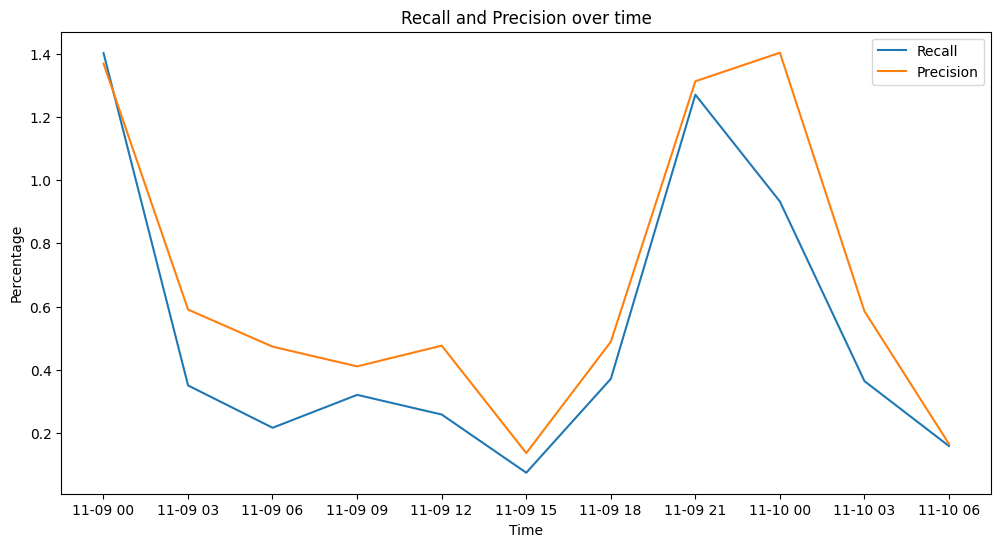

In [58]:
# plot recall and precision against time
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(window_df['time'], window_df['recall'], label='Recall')
plt.plot(window_df['time'], window_df['precision'], label='Precision')
plt.xlabel('Time')
plt.ylabel('Percentage')
plt.title('Recall and Precision over time')
plt.legend()
plt.show()

In [ ]:
precision = correct / total*10
recall = correct / len(all_imps)*100
print(precision, recall)

In [ ]:
correct

In [ ]:
for user in preds:
    print(all([l in all_imps for l in preds[user]]))

    # print(user, preds[user], all_testsets[user])
    # break

In [ ]:
for user in preds:
    intersection = all_testsets[user].intersection(preds[user])
    if len(intersection) == 0:
        continue
    print(intersection, user)

In [ ]:
testset[testset['UserID'] == 'U92212'].Impressions.values[0]

In [ ]:
interactions_preds_dict = {}
all_articles = set(news_data['ArticleID'].unique())

#randomly sample 10000 interactions

for iter, row in tqdm(test_df.sample(200, random_state=42).iterrows()):
    if row['UserHistory'] == '':
        continue
    interactionid = row['ImpressionID']
    history = row['UserHistory'].split(' ')
    impressions = row['Impressions'].split(' ')
    sorted_articles = recommend_similar_article(history, all_articles, similarity_matrix, article_index_dict, 40)
    interactions_preds_dict[interactionid] = (sorted_articles, impressions)

In [ ]:
recs = []
for interactionid, (preds, impressions) in interactions_preds_dict.items():
    for article, predicted_sim in preds:
        if f'{article}-1' in impressions or f'{article}-0' in impressions:
            recs.append((interactionid, article, predicted_sim, 1 if f'{article}-1' in impressions else 0))